# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import os

path = os.getcwd()

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = path+r'/train.p'
testing_file = path+r'/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import random
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

#### Display a random image from training set along with its label

25


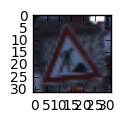

In [5]:
### Display a random image from training set along with its label
index = random.randint(0, len(X_train))
image = X_train[index]

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

#### Display distribution of each label in the training set

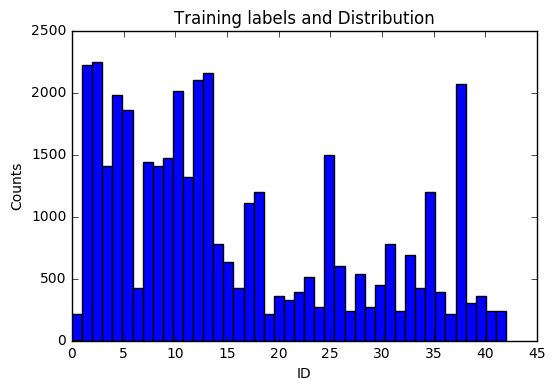

In [6]:
### Display distribution of each label in the training set

plt.hist(y_train,bins=43)
plt.title("Training labels and Distribution")
plt.xlabel("ID")
plt.ylabel("Counts")


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
### Do affine transformations like rotation,translation and shearing

# this function translates an image
def translate(img,trans_range):
    rows,cols,ch = img.shape 
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    return img

# this function rotates an image
def rotate(img,ang_range):
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    return img

# this function blurs an image
def blur(img,k_size):
    img = cv2.GaussianBlur(img,(k_size,k_size),0)
    return img

# this function scales an image
def scale(img,min,max):
    scl_by = round(random.uniform(min, max), 1)
    img = cv2.resize(img,None,fx=scl_by, fy=scl_by, interpolation = cv2.INTER_LINEAR)
    return img

# nomalize 
def normalizer(image_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

# get y component
def get_y_component(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    gray = gray[:,:,0]
    return gray

# normalize y value of an image
def normalize_y(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img[:,:,0] = normalizer(img[:,:,0])
    return img

#### Visualize affine transformations for an image

In [ ]:
"""""visualize_image = X_train[1]
plt.imshow(visualize_image);
plt.axis('off');
plt.show()


gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(visualize_image,20,10,5)

    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()""""

### Rebalancing Classes

As the classes are imbalanced so making them balanced by below functions
* **generate_labels:** takes list of training labels and randomly select indices for each class from the list and returns 1000 indices per class

* **generate_images:** takes list from generate_labels and returns transformed images, i.e. returns 1000 transformed images per class id

In [9]:
def generate_labels(lbl_list):
    img_list = []
    for i in range(43):
        index_list = list(np.where(lbl_list==i)[0])
        for j in range(500):
            rand_index = random.choice(index_list)
            img_list.append([rand_index,i])
    return img_list

def generate_images(raw_images,lbl_list):
    images = np.zeros(43*500*5*32*32*3)
    images = images.reshape(43*500*5,32,32,3)
    labels = []
    img_list = generate_labels(lbl_list)
    k = 0
    for i in img_list:
        #add original image to list
        images[k]=raw_images[i[0]]
        k = k+1
        labels.append(i[1])
        #add translated image
        images[k]=translate(raw_images[i[0]],4)
        k = k+1
        labels.append(i[1])
        #add rotated image
        images[k] = rotate(raw_images[i[0]],20)
        k = k+1
        labels.append(i[1])
        #add blurred image
        images[k] = blur(raw_images[i[0]],3)
        k = k+1
        labels.append(i[1])
        #add scaled image
        #images[k] = scale(raw_images[i[0]],0.5,1.5)
        #k = k+1
        #labels.append(i[1])
        #add normalized y image
        images[k] = normalize_y(raw_images[i[0]])
        k = k+1
        labels.append(i[1])
    return images,np.array(labels)

#### Rebalancing training set

In [10]:
images,labels = generate_images(X_train,y_train)

In [11]:
print(type(images))
print(images.shape)
print(type(labels))


<class 'numpy.ndarray'>
(107500, 32, 32, 3)
<class 'numpy.ndarray'>


### Gray

In [ ]:
"""def convert(img_list):
    output = []
    for i in img_list:
        c = normalize_y(i)
        output.append(c)
    return output"""

In [ ]:
#X_train = convert(X_train)

0


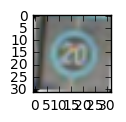

In [15]:
### Display a random image from training set along with its label
#index = random.randint(0, len(images))
index = 1002
image9 = images[index]
#image9 = cv2.cvtColor(image9, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(1,1))
plt.imshow(image9)
print(labels[index])
#print(image9)

#### Veify image and class id are correct

In [ ]:
"""### Veify image and class id are correct
#k = 14000*2
#image2 = images[k]
image2 = X_train[0]
plt.figure(figsize=(1,1))
plt.imshow(image2)
print(labels[k])"""

### Split training set into training and validtion

In [16]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    images,
    labels,
    test_size=0.15,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.



### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


#### Step 1: Tensorflow set-up

Initializing number of epochs and batch size

In [23]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 256

#### Step 2: Defining Architecture
* **Input Size:** 32x32x3
* **Layer 1: Convolutional.** The output shape should be 28x28x6.
* **Activation:** Relu.
* **Pooling:** The output shape should be 14x14x6.
* **Layer 2: Convolutional.** The output shape should be 10x10x16.
* **Activation:** Relu.
* **Pooling:** The output shape should be 5x5x16.
* **Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.
* **Layer 3: Fully Connected.** This should have 120 outputs.
* **Activation:** Relu.
* **Layer 4: Fully Connected.** This should have 84 outputs.
* **Activation:** Relu.
* **Layer 5: Fully Connected (Logits).** This should have 43 outputs.

#### Output
Return the result of the 2nd fully connected layer.

In [18]:
from tensorflow.contrib.layers import flatten

#keep_prob = tf.placeholder(tf.float32)

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    #droput 1
    #conv1 = tf.nn.dropout(conv1,keep_prob)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    #droput 2
    #conv2 = tf.nn.dropout(conv2,keep_prob)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    #droput 3
    #fc1 = tf.nn.dropout(fc1,keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    #droput 4
    #fc2 = tf.nn.dropout(fc2,keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

#### Step 3: Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

#### Step 4: Training Pipeline
* Defining Learning rate
* Cross entropy
* Loss
* Optimizer and running optimizer to minimize the loss

In [20]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Step 5: Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})    #feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Step 6: Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(1,EPOCHS+1):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})   #feed_dict={x: batch_x, y: batch_y,keep_prob:0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        #if (i%10 == 0):
        print("EPOCH {} ...".format(i))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, r'/home/carnd/CarND-Traffic-Sign-Classifier-Project/Models/lenet_preprocess.ckpt')

    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.723

EPOCH 2 ...
Validation Accuracy = 0.812

EPOCH 3 ...
Validation Accuracy = 0.851

EPOCH 4 ...
Validation Accuracy = 0.869

EPOCH 5 ...
Validation Accuracy = 0.874

EPOCH 6 ...
Validation Accuracy = 0.891

EPOCH 7 ...
Validation Accuracy = 0.887

EPOCH 8 ...
Validation Accuracy = 0.886

EPOCH 9 ...
Validation Accuracy = 0.905

EPOCH 10 ...
Validation Accuracy = 0.911

EPOCH 11 ...
Validation Accuracy = 0.916

EPOCH 12 ...
Validation Accuracy = 0.912

EPOCH 13 ...
Validation Accuracy = 0.919

EPOCH 14 ...
Validation Accuracy = 0.914

EPOCH 15 ...
Validation Accuracy = 0.925

EPOCH 16 ...
Validation Accuracy = 0.926

EPOCH 17 ...
Validation Accuracy = 0.925

EPOCH 18 ...
Validation Accuracy = 0.922

EPOCH 19 ...
Validation Accuracy = 0.933

EPOCH 20 ...
Validation Accuracy = 0.939

Model saved


In [ ]:
actual_labels = tf.argmax(one_hot_y, 1)
predicted_labels = tf.argmax(logits, 1)
is_correct_prediction = tf.cast(correct_prediction, tf.int64)

#pred = tf.cast(correct_prediction, tf.int64) #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
z = tf.pack([actual_labels,predicted_labels,is_correct_prediction])

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, r'/home/carnd/CarND-Traffic-Sign-Classifier-Project/Models/lenet_preprocess.ckpt')
    acc_per_lbl={}
    for k in range(43):
        acc_per_lbl[k] = [0,0]
    n = len(X_validation)
    
    for offset in range(0, n, BATCH_SIZE):
        batch_x, batch_y = X_validation[offset:offset+BATCH_SIZE], y_validation[offset:offset+BATCH_SIZE]
        temp = sess.run(z,feed_dict={x: batch_x, y: batch_y})
        for i in range(43):
            indices = np.where(temp[0]==i)[0]
            count = len(indices)
            correct = np.sum(temp[2][indices])
            acc_per_lbl[i][0] += correct
            acc_per_lbl[i][1] += count
        
print(temp)
print(acc_per_lbl)

In [ ]:
acc_per_lbl_percentage = []
for i in range(43):
    acc_per_lbl_percentage.append(acc_per_lbl[i][0]*100./acc_per_lbl[i][1])
acc_per_lbl_percentage = np.array(acc_per_lbl_percentage)

print(acc_per_lbl_percentage)

numer = 0
denom = 0
for i in range(43):
    numer += acc_per_lbl[i][0]
    denom += acc_per_lbl[i][1]
print(numer*100./denom)
    

In [ ]:
### Display distribution of each label in the training set

plt.plot(range(0,43),acc_per_lbl_percentage)
plt.title("Training labels and Distribution")
plt.xlabel("ID")
plt.ylabel("percentage")


#### Step 7: Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [25]:
with tf.Session() as sess:
    saver.restore(sess, r'/home/carnd/CarND-Traffic-Sign-Classifier-Project/Models/lenet_preprocess.ckpt')

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.894


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.